## Notebook Final

La presente notebook tiene como objetivo unificar el dataset de Airbnb y de Delitos. Realizar análisis y aplicación de KMEANS y DBSCAN

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

In [4]:
#Importo los datasets generados
delitos = pd.read_csv("delitos_final.csv")
airbnb = pd.read_csv("airbnb_final.csv")

In [5]:
# 1. Listas de nombres de barrios únicos en cada DataFrame
barrios_airbnb = set(airbnb["barrio_corregido"].str.upper().str.strip())
barrios_delitos = set(delitos["barrio"].str.upper().str.strip())

# 2. Comparar diferencias
barrios_solo_en_airbnb = barrios_airbnb - barrios_delitos
barrios_solo_en_delitos = barrios_delitos - barrios_airbnb

print("Barrios en Airbnb pero no en Delitos:")
print(sorted(barrios_solo_en_airbnb))

print("\nBarrios en Delitos pero no en Airbnb:")
print(sorted(barrios_solo_en_delitos))


Barrios en Airbnb pero no en Delitos:
['NUÑEZ']

Barrios en Delitos pero no en Airbnb:
['NUNEZ']


In [6]:
# Normalizar nombres de barrios en ambos datasets (mayúsculas y sin espacios extra)
airbnb["barrio_corregido"] = airbnb["barrio_corregido"].str.upper().str.strip()
delitos["barrio"] = delitos["barrio"].str.upper().str.strip()


In [7]:
# Reemplazar 'NUNEZ' por 'NUÑEZ' en el dataset de delitos
delitos['barrio'] = delitos['barrio'].replace({'NUNEZ': 'NUÑEZ'})


In [8]:
# Volvemos a extraer los sets con los nombres ya corregidos
barrios_airbnb = set(airbnb["barrio_corregido"])
barrios_delitos = set(delitos["barrio"])

# Barrios presentes en Airbnb pero no en Delitos
solo_airbnb = barrios_airbnb - barrios_delitos

# Barrios presentes en Delitos pero no en Airbnb
solo_delitos = barrios_delitos - barrios_airbnb

# Mostrar resultados
print("Barrios en Airbnb pero no en Delitos:")
print(sorted(solo_airbnb))

print("\nBarrios en Delitos pero no en Airbnb:")
print(sorted(solo_delitos))


Barrios en Airbnb pero no en Delitos:
[]

Barrios en Delitos pero no en Airbnb:
[]


In [9]:
# Merge final
df_final = pd.merge(airbnb, delitos, left_on='barrio_corregido', right_on='barrio', how='inner')


In [10]:
df_final.columns

Index(['barrio_corregido', 'ocupacion_aproximada', 'ocupacion_aproximada_mes',
       'cantidad_propiedades', 'Entire home/apt', 'Hotel room_y',
       'Private room', 'Shared room', 'precio_entire_home', 'Hotel room_x',
       'precio_private_room', 'precio_shared_room', 'barrio', 'total_delitos',
       'tipo_mas_frecuente'],
      dtype='object')

In [11]:
# 1. Eliminar la columna "barrio" si existe, ya que quedo barrio_corregido
if "barrio" in df_final.columns:
    df_final.drop(columns=["barrio"], inplace=True)


In [12]:
# 2. Renombrar "barrio_corregido" a "barrio"
df_final.rename(columns={"barrio_corregido": "barrio"}, inplace=True)

In [13]:
df_final.rename(columns={"Hotel room_x": "precio_hotel_room"}, inplace=True)
df_final.rename(columns={"Hotel room_y": "Hotel_room"}, inplace=True)


In [14]:
# Rellenar precios NaN con 0 si no se ofrece ese tipo de habitación
df_final["precio_entire_home"] = df_final["precio_entire_home"].fillna(0)
df_final["precio_private_room"] = df_final["precio_private_room"].fillna(0)
df_final["precio_shared_room"] = df_final["precio_shared_room"].fillna(0)
df_final["precio_hotel_room"] = df_final["precio_hotel_room"].fillna(0)
df_final["ocupacion_aproximada_mes"] = df_final["ocupacion_aproximada_mes"].fillna(0)

### Saco los barrios que no tiene ocupacion aproximada y lo guardo en *df_filtrado*

In [16]:
barrios_excluir = ["VILLA RIACHUELO", "VILLA SOLDATI"]
df_filtrado = df_final[~df_final["barrio"].isin(barrios_excluir)]

In [17]:
df_filtrado

,barrio,ocupacion_aproximada,ocupacion_aproximada_mes,cantidad_propiedades,Entire home/apt,Hotel_room,Private room,Shared room,precio_entire_home,precio_hotel_room,precio_private_room,precio_shared_room,total_delitos,tipo_mas_frecuente
0,AGRONOMIA,0.003691,0.112359,36,0.833333,0.000000,0.166667,0.000000,36758.0,0.0,15753.0,0.0,527,Hurto
1,ALMAGRO,0.004861,0.147964,1312,0.860518,0.000000,0.130335,0.009146,35350.0,0.0,19954.0,12603.0,6098,Robo
2,BALVANERA,0.005013,0.152600,1279,0.765442,0.000782,0.232213,0.001564,33607.0,0.0,18904.0,45411.5,9996,Robo
3,BARRACAS,0.004832,0.147074,263,0.806084,0.000000,0.190114,0.003802,45684.5,0.0,18935.5,15753.0,5523,Robo
4,BELGRANO,0.005709,0.173796,1832,0.938319,0.000000,0.060044,0.001638,42009.0,0.0,22895.0,10502.0,4989,Hurto
5,BOCA,0.004574,0.139246,128,0.804688,0.000000,0.179688,0.015625,36758.0,0.0,21004.0,17219.5,2556,Robo
6,BOEDO,0.003398,0.103430,119,0.798319,0.000000,0.201681,0.000000,31086.0,0.0,16803.0,0.0,2052,Hurto
7,CABALLITO,0.004949,0.150639,676,0.872781,0.000000,0.127219,0.000000,35633.5,0.0,21004.0,0.0,6559,Hurto
8,CHACARITA,0.005909,0.179863,603,0.865672,0.000000,0.129353,0.004975,36758.0,0.0,19503.0,55514.0,2432,Robo
9,COGHLAN,0.005019,0.152767,122,0.942623,0.000000,0.057377,0.000000,32557.0,0.0,21004.0,0.0,547,Hurto


### Calculo el precio promedio ponderado

In [19]:
df_final["precio_promedio_ponderado"] = (
    df_final["precio_entire_home"] * df_final["Entire home/apt"] +
    df_final["precio_private_room"] * df_final["Private room"] +
    df_final["precio_shared_room"] * df_final["Shared room"]+
    df_final["precio_hotel_room"] * df_final["Hotel_room"]
    
) / df_final[["Entire home/apt", "Private room", "Shared room","Hotel_room"]].sum(axis=1)

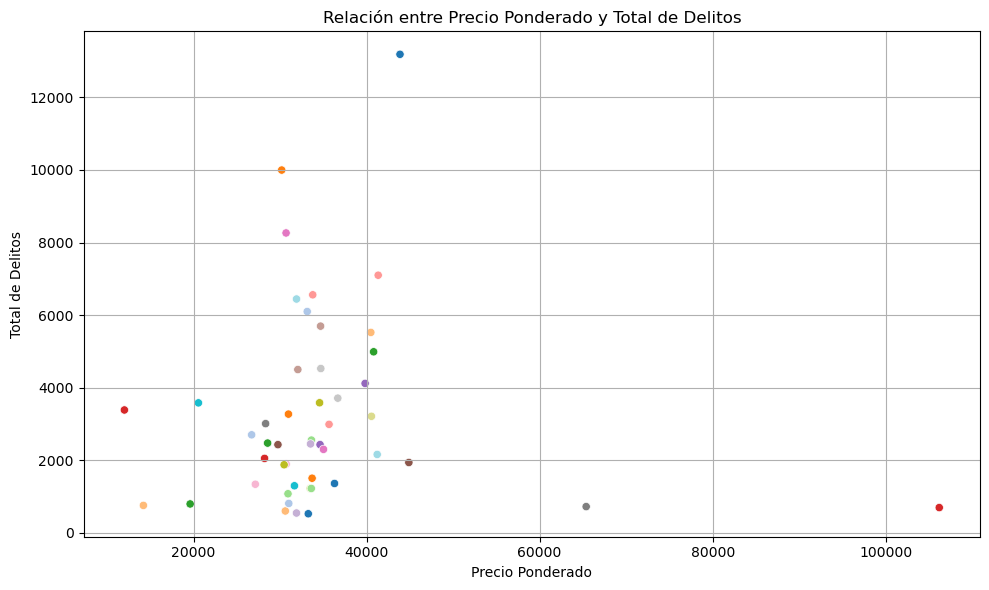

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x="precio_promedio_ponderado", y="total_delitos", hue="barrio", palette="tab20", legend=False)
plt.title("Relación entre Precio Ponderado y Total de Delitos")
plt.xlabel("Precio Ponderado")
plt.ylabel("Total de Delitos")
plt.grid(True)
plt.tight_layout()
plt.show()



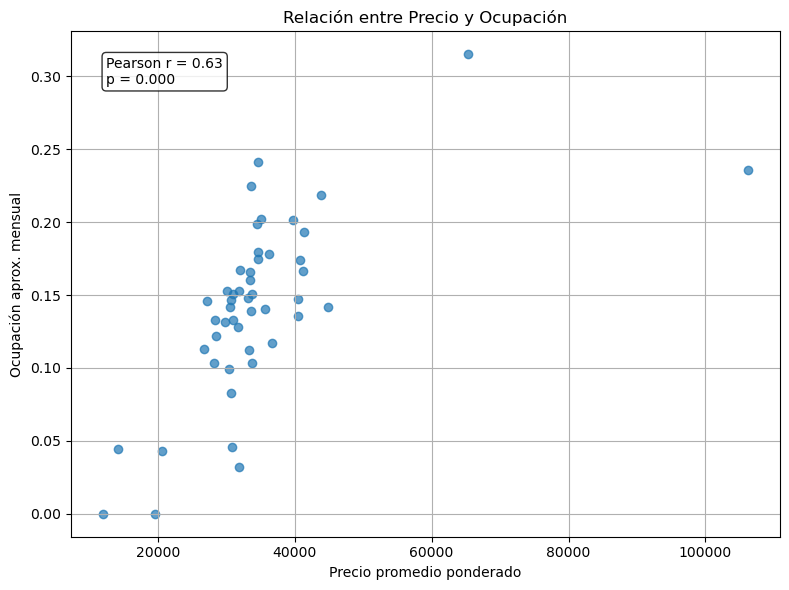

In [21]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Asume que df_final tiene las columnas:
#   - 'precio_promedio_ponderado'
#   - 'ocupacion_aproximada_mes'

x = df_final['precio_promedio_ponderado']
y = df_final['ocupacion_aproximada_mes']

# 1. Scatter
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Precio promedio ponderado")
plt.ylabel("Ocupación aprox. mensual")
plt.title("Relación entre Precio y Ocupación")
plt.grid(True)

# 2. Correlación de Pearson
r, p_value = stats.pearsonr(x, y)
plt.annotate(f"Pearson r = {r:.2f}\np = {p_value:.3f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             ha='left', va='top',
             bbox=dict(boxstyle='round', fc='white', alpha=0.8))

plt.tight_layout()
plt.show()


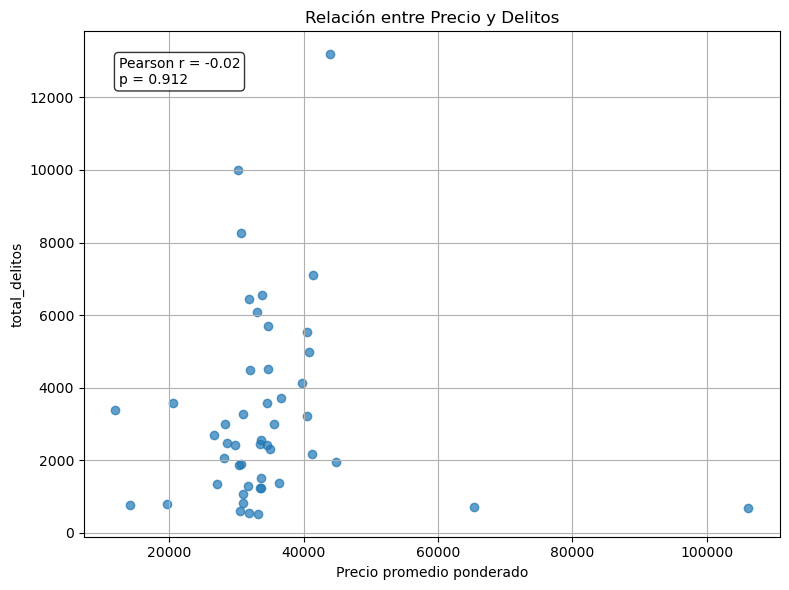

In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Asume que df_final tiene las columnas:
#   - 'precio_promedio_ponderado'
#   - 'ocupacion_aproximada_mes'

x = df_final['precio_promedio_ponderado']
y = df_final['total_delitos']

# 1. Scatter
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Precio promedio ponderado")
plt.ylabel("total_delitos")
plt.title("Relación entre Precio y Delitos")
plt.grid(True)

# 2. Correlación de Pearson
r, p_value = stats.pearsonr(x, y)
plt.annotate(f"Pearson r = {r:.2f}\np = {p_value:.3f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             ha='left', va='top',
             bbox=dict(boxstyle='round', fc='white', alpha=0.8))

plt.tight_layout()
plt.show()


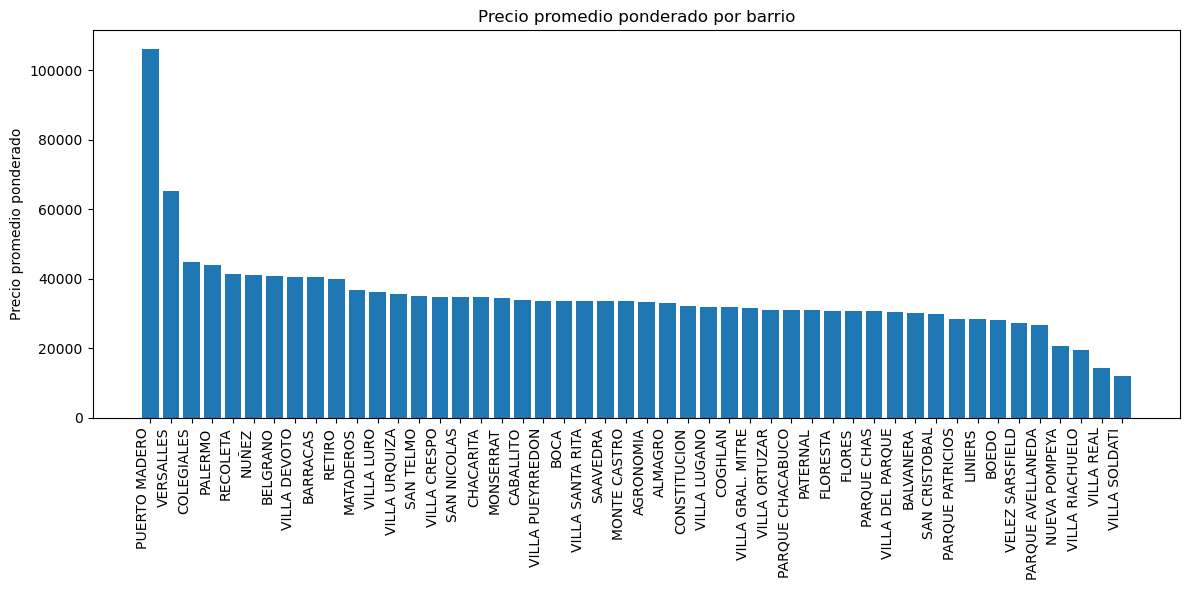

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
#ordenado
df_plot = df_final.sort_values("precio_promedio_ponderado", ascending=False)

plt.bar(df_plot["barrio"], df_plot["precio_promedio_ponderado"])
plt.xticks(rotation=90, ha="right")
plt.ylabel("Precio promedio ponderado")
plt.title("Precio promedio ponderado por barrio")
plt.tight_layout()
plt.show()


C:\Users\maria\AppData\Local\Temp\ipykernel_18448\3993993719.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


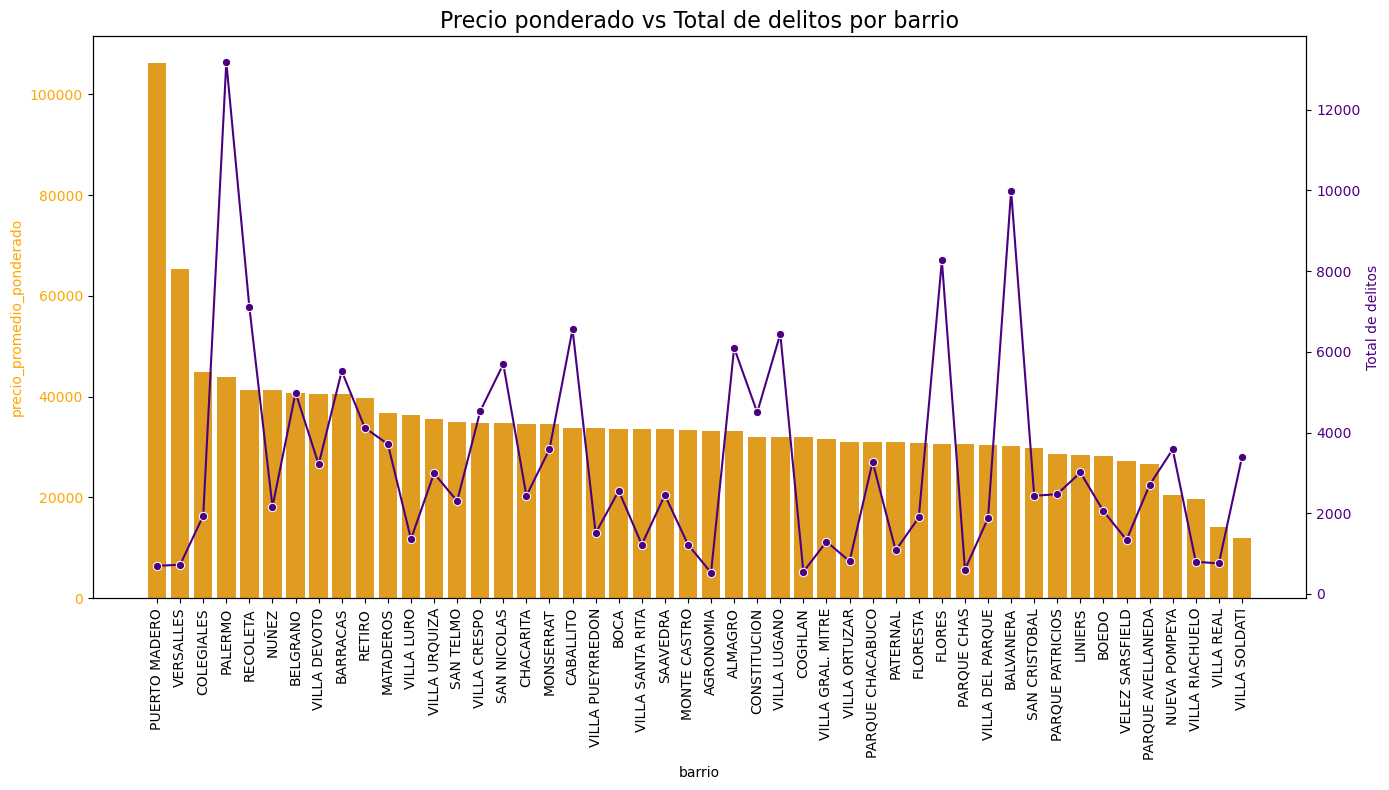

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar por precio mediano para visualización
df_plot = df_final.sort_values("precio_promedio_ponderado", ascending=False)

# Crear figura
fig, ax1 = plt.subplots(figsize=(14, 8))

# Barra 1: Precio mediano
sns.barplot(
    data=df_plot,
    x="barrio",
    y="precio_promedio_ponderado",
    color="orange",
    ax=ax1
)
ax1.set_ylabel("precio_promedio_ponderado", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Crear segundo eje Y
ax2 = ax1.twinx()

# Barra 2: Total delitos (como línea)
sns.lineplot(
    data=df_plot,
    x="barrio",
    y="total_delitos",
    color="indigo",
    marker="o",
    ax=ax2
)
ax2.set_ylabel("Total de delitos", color="indigo")
ax2.tick_params(axis="y", labelcolor="indigo")

# Título
plt.title("Precio ponderado vs Total de delitos por barrio", fontsize=16)
plt.tight_layout()
plt.show()

## clustering ponderado

In [26]:
df_final["ocupacion_aproximada_mes"].fillna(0, inplace=True)

C:\Users\maria\AppData\Local\Temp\ipykernel_18448\25829298.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final["ocupacion_aproximada_mes"].fillna(0, inplace=True)


In [27]:
#Escalo las variables
from sklearn.preprocessing import StandardScaler

# Seleccionamos solo las columnas numéricas para clustering
variables_cluster_ponderado = df_final[["precio_promedio_ponderado","total_delitos"]].copy()

# Escalar las variables
scaler_ponderado = StandardScaler()
variables_scaled_ponderado = scaler_ponderado.fit_transform(variables_cluster_ponderado)


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

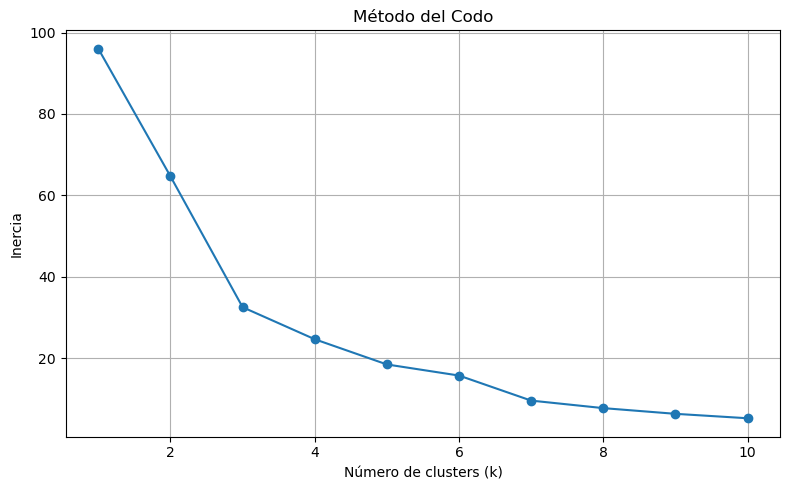

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Método del codo
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(variables_scaled_ponderado)
    inertia.append(kmeans.inertia_)

# Graficar la curva del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Entrenar KMeans
kmeans_final_ponderado = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_final["cluster_ponderado"] = kmeans_final_ponderado.fit_predict(variables_scaled_ponderado)

# Ver el resultado
df_final[["barrio", "cluster_ponderado"] + list(variables_cluster_ponderado.columns)]

C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,barrio,cluster_ponderado,precio_promedio_ponderado,total_delitos
0,AGRONOMIA,0,33257.166667,527
1,ALMAGRO,2,33135.304878,6098
2,BALVANERA,2,30184.960125,9996
3,BARRACAS,2,40485.330798,5523
4,BELGRANO,2,40809.730895,4989
5,BOCA,0,33621.914062,2556
6,BOEDO,0,28205.394958,2052
7,CABALLITO,2,33772.350592,6559
8,CHACARITA,0,34619.323383,2432
9,COGHLAN,0,31894.122951,547


In [30]:
# Cuantos barrios quedaron por cluster
df_final['cluster_ponderado'].value_counts().sort_index()

cluster_ponderado
0    37
1     1
2    10
Name: count, dtype: int64

Text(0.5, 1.0, 'Centroides por variable km ponderado(estandarizados)')

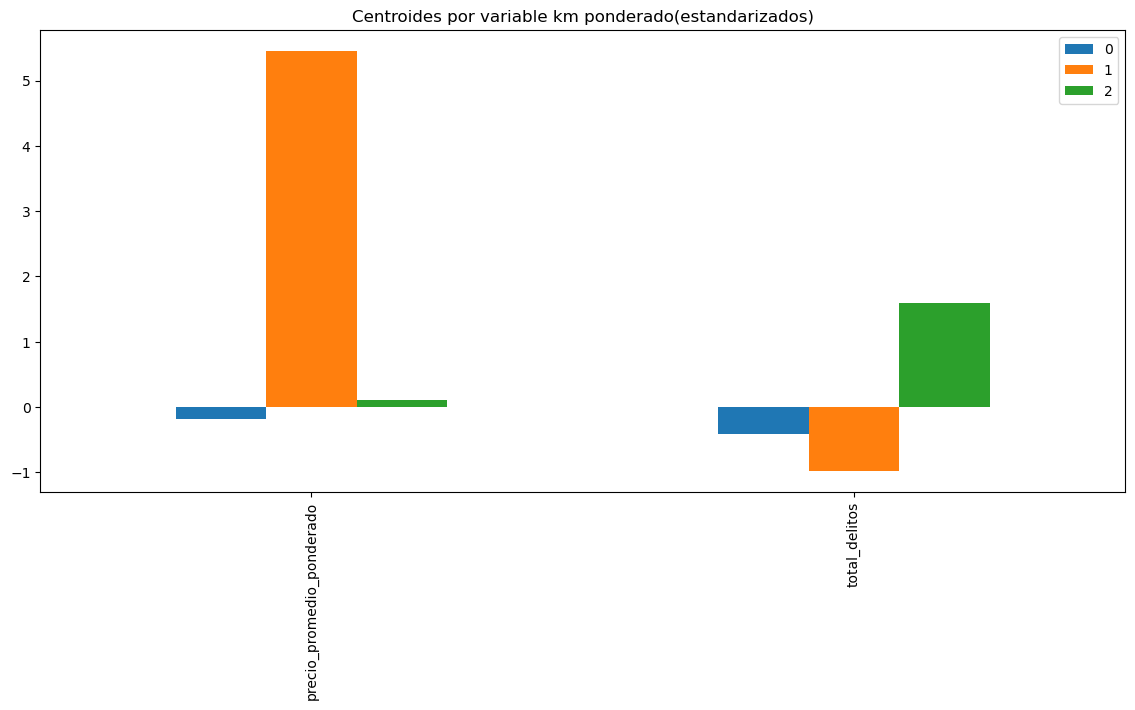

In [31]:
centroides = pd.DataFrame(kmeans_final_ponderado.cluster_centers_, columns=variables_cluster_ponderado.columns)
centroides.T.plot(kind='bar', figsize=(14, 6))
plt.title("Centroides por variable km ponderado(estandarizados)")

In [32]:
#df_final[df_final["cluster_ponderado"] == 1]

In [33]:
#df_final[df_final["cluster_ponderado"] == 0]

In [34]:
#df_final[df_final["cluster_ponderado"] == 2]

In [35]:
from sklearn.metrics import silhouette_score

# Calcula el Silhouette Score
sil_score = silhouette_score(variables_scaled_ponderado, df_final["cluster_ponderado"])

print(f"Silhouette Score para KMeans (k=3): {sil_score:.4f}")


Silhouette Score para KMeans (k=3): 0.5129


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


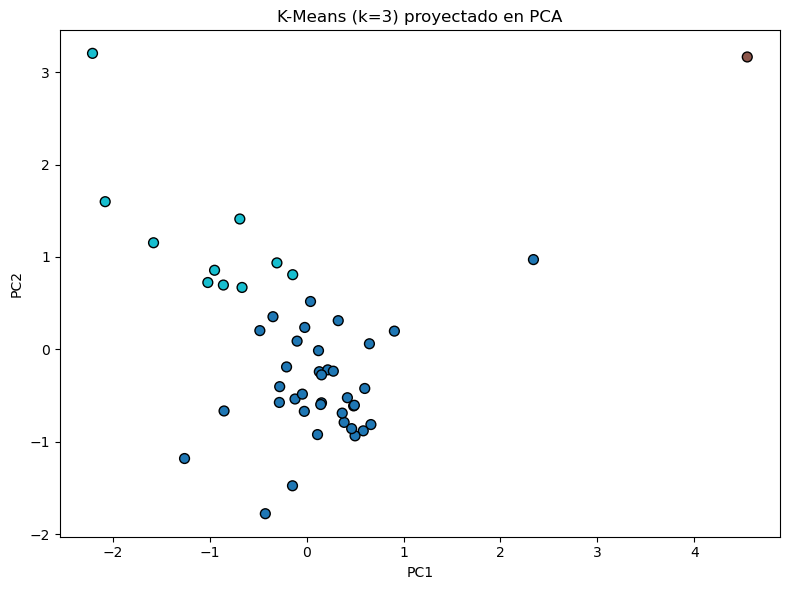

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Entrenar KMeans con k=3 y asignar a df_final
km4 = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_final["cluster_km4"] = km4.fit_predict(variables_scaled_ponderado)

# 2. Proyección PCA a 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(variables_scaled_ponderado)

# 3. Scatter coloreado por cluster_km4
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df_final["cluster_km4"],
    cmap="tab10",
    s=50,
    edgecolor="k"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means (k=3) proyectado en PCA")
plt.tight_layout()
plt.show()



In [37]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 1. Cargar el shapefile de barrios
barrios_gdf = gpd.read_file("C:\\Users\\maria\\Desktop\\Euge\\maestria\\TT1\\barrios\\barrios.shp") 

# 2. Asegurarse de que esté en el CRS correcto
barrios_gdf = barrios_gdf.to_crs(epsg=4326)  # Lat/lon
barrios_gdf = barrios_gdf.rename(columns={'nombre': 'barrio'})

C:\Users\maria\AppData\Local\Temp\ipykernel_18448\579490193.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = mapa_clusters.geometry.centroid


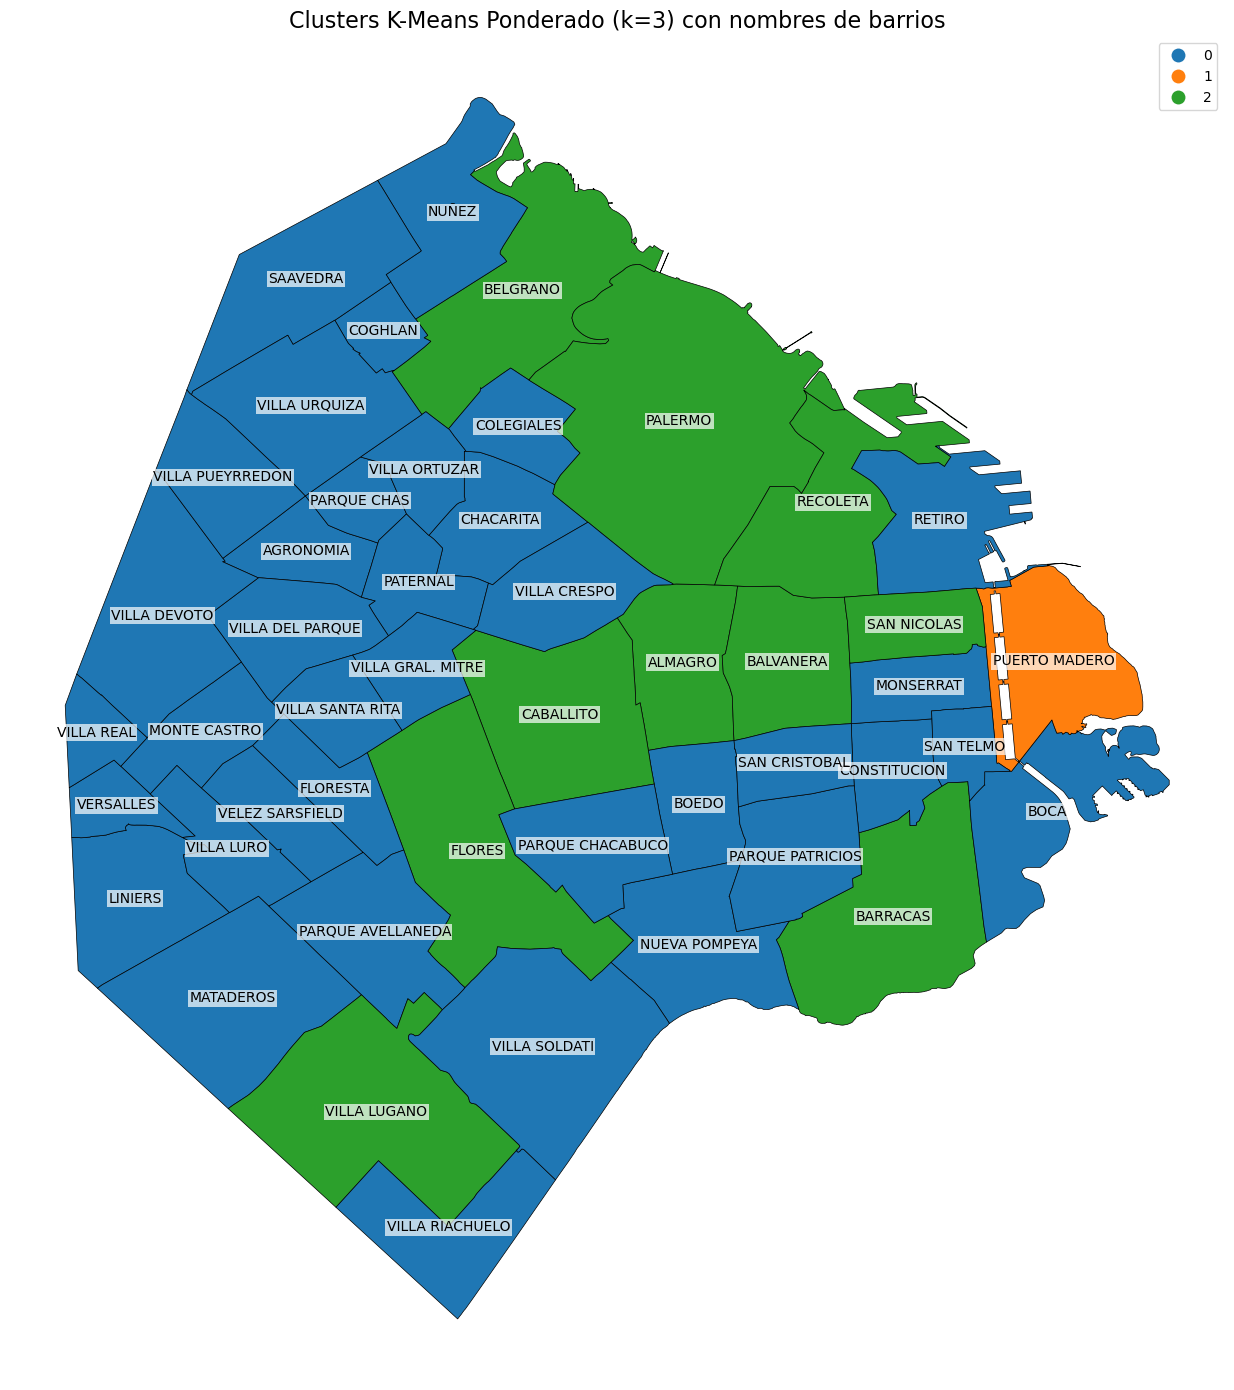

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap

# 1. Merge de nuevo
mapa_clusters = barrios_gdf.merge(
    df_final[['barrio', 'cluster_ponderado']],
    on='barrio',
    how='left'
)
mapa_clusters
# 2. Definir colores personalizados para cada cluster
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # celeste, naranja, verde
cmap = ListedColormap(colors)

# 3. Gráfico con nombres
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
mapa_clusters.plot(
    column="cluster_ponderado",
    categorical=True,
    cmap=cmap,
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Dibujar nombres con fondo blanco
centroids = mapa_clusters.geometry.centroid
for idx, row in mapa_clusters.iterrows():
    x, y = centroids.loc[idx].x, centroids.loc[idx].y
    ax.text(
        x, y, row["barrio"],
        fontsize=10,  # Tamaño de fuente mayor
        ha="center", va="center",
        color="black",
        bbox=dict(
            facecolor="white", 
            edgecolor="none", 
            pad=1, 
            alpha=0.7
        )
    )

ax.set_title("Clusters K-Means Ponderado (k=3) con nombres de barrios", fontsize=16)
ax.axis("off")
plt.tight_layout()

# 4. Guardar la figura
fig.savefig("clusters_km_ponderado_barrio.png", dpi=300, bbox_inches="tight")

plt.show()


### ARI PONDERADO

In [40]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Datos: matriz escalada y etiquetas originales de k-means (k=3)
X = variables_scaled_ponderado
labels_orig = df_final["cluster_ponderado"].values

# 1. Bootstrap
B = 100
aris_boot = []
for _ in range(B):
    idx = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
    X_sample = X[idx]
    km = KMeans(n_clusters=3, random_state=42, n_init='auto')
    labels_sample = km.fit_predict(X_sample)
    aris_boot.append(adjusted_rand_score(labels_orig[idx], labels_sample))

# 2. Submuestreo (hold-out 80%)
N = 50
aris_sub = []
n_sub = int(0.8 * len(X))
for _ in range(N):
    idx = np.random.choice(np.arange(len(X)), size=n_sub, replace=False)
    X_sub = X[idx]
    km = KMeans(n_clusters=3, random_state=42, n_init='auto')
    labels_sub = km.fit_predict(X_sub)
    aris_sub.append(adjusted_rand_score(labels_orig[idx], labels_sub))

# Resultados
results_ponderado = pd.DataFrame({
    "Método": ["Bootstrap (B=100)", "Submuestreo 80% (N=50)"],
    "ARI Medio": [np.mean(aris_boot), np.mean(aris_sub)],
    "ARI STD": [np.std(aris_boot), np.std(aris_sub)]
})

import pprint
pprint.pprint(results_ponderado)


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

                   Método  ARI Medio   ARI STD
0       Bootstrap (B=100)   0.651228  0.251331
1  Submuestreo 80% (N=50)   0.753354  0.235757


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Clustering dbscan ponderado

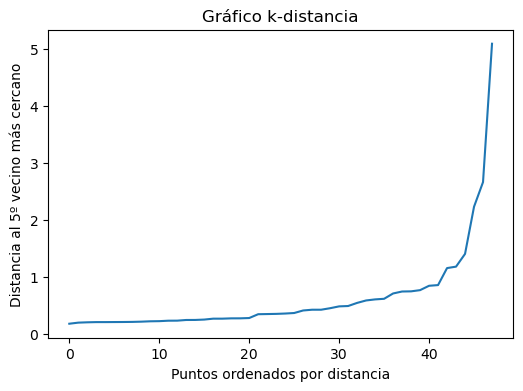

In [42]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
features =  ["precio_promedio_ponderado","total_delitos"
            ]
    
X = df_final[features]

# 2. Escalo variables (muy importante para DBSCAN)
scaler_dbscan = StandardScaler()
X_scaled_dbscan = scaler_dbscan.fit_transform(X)

# 3. Gráfico k-distancia para elegir eps
# uso min_samples=5 la distancia al 5º vecino
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled_dbscan)
distances, _ = nbrs.kneighbors(X_scaled_dbscan)
distances = np.sort(distances[:, 4])  # 4 = índice del 5º vecino (0-index)
plt.figure(figsize=(6,4))
plt.plot(distances)
plt.ylabel("Distancia al 5º vecino más cercano")
plt.xlabel("Puntos ordenados por distancia")
plt.title("Gráfico k-distancia")
plt.show()

In [43]:
import numpy as np
from sklearn.cluster import DBSCAN

for eps in [1.8, 2.1, 2.5, 3.0]:
    for ms in [3, 5]:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled_dbscan)
        unique, counts = np.unique(labels, return_counts=True)
        print(f"eps={eps}, min_samples={ms} → Clusters:", dict(zip(unique, counts)))


eps=1.8, min_samples=3 → Clusters: {-1: 1, 0: 47}
eps=1.8, min_samples=5 → Clusters: {-1: 1, 0: 47}
eps=2.1, min_samples=3 → Clusters: {-1: 1, 0: 47}
eps=2.1, min_samples=5 → Clusters: {-1: 1, 0: 47}
eps=2.5, min_samples=3 → Clusters: {-1: 1, 0: 47}
eps=2.5, min_samples=5 → Clusters: {-1: 1, 0: 47}
eps=3.0, min_samples=3 → Clusters: {-1: 1, 0: 47}
eps=3.0, min_samples=5 → Clusters: {-1: 1, 0: 47}


In [44]:
# 4. Ajusto DBSCAN
db = DBSCAN(eps=1.8, min_samples=3)
labels = db.fit_predict(X_scaled_dbscan)

In [45]:
# 5. Convierto etiquetas en columna y analizo
df_final["cluster_dbscan"] = labels
print(df_final["cluster_dbscan"].value_counts())

cluster_dbscan
 0    47
-1     1
Name: count, dtype: int64


In [46]:
#Los barrios que son considerados como ruido
df_ruido = df_final.loc[
    df_final["cluster_dbscan"] == -1,
    ["barrio", "precio_promedio_ponderado", "total_delitos"]
]
df_ruido


,barrio,precio_promedio_ponderado,total_delitos
26,PUERTO MADERO,106185.365196,697


## Calculo métricas de Boulin,silhouette_score

In [48]:
features = [
   "precio_promedio_ponderado",
    "total_delitos"
]
X = df_final[features]
X_scaled = StandardScaler().fit_transform(X)

# 1. K-Means
k = 3
km = KMeans(n_clusters=k, random_state=42)
labels_km = km.fit_predict(variables_scaled_ponderado)
sil_km = silhouette_score(variables_scaled_ponderado, labels_km)
db_km = davies_bouldin_score(variables_scaled_ponderado, labels_km)

# 2. DBSCAN (incluyendo ruido como cluster)
eps = 1.5
min_samples = 2
db = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = db.fit_predict(X_scaled_dbscan)
unique_labels_db = np.unique(labels_db)

# Calcula métricas incluyendo el ruido (-1 como un label más)
if len(unique_labels_db) >= 2:
    sil_db = silhouette_score(X_scaled_dbscan, labels_db)
    db_db = davies_bouldin_score(X_scaled_dbscan, labels_db)
else:
    sil_db = np.nan
    db_db = np.nan

# 3. DataFrame de comparación
df_comp = pd.DataFrame({
    "Método": ["KMeans", "DBSCAN"],
    "Clusters_detectados": [k, len(unique_labels_db)],
    "% Ruido": [0, (labels_db == -1).mean() * 100],
    "Silhouette": [sil_km, sil_db],
    "Davies–Bouldin": [db_km, db_db]
})

print(df_comp)



   Método  Clusters_detectados  % Ruido  Silhouette  Davies–Bouldin
0  KMeans                    3     0.00    0.512937        0.522000
1  DBSCAN                    2     6.25    0.664342        1.191356


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


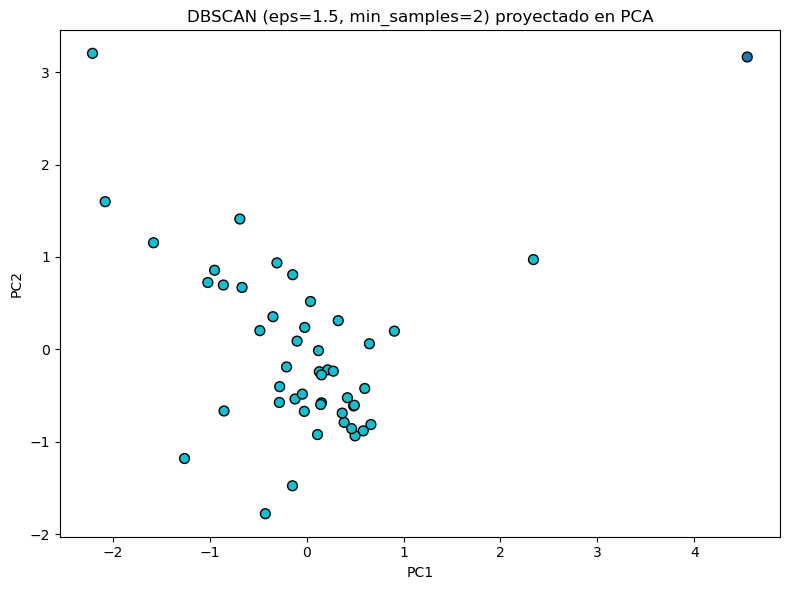

In [49]:
# 1. Proyección PCA sobre X_scaled_dbscan
pca_db = PCA(n_components=2, random_state=42)
X_pca_db = pca_db.fit_transform(X_scaled_dbscan)

# 2. Scatter coloreado por labels de DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca_db[:, 0], X_pca_db[:, 1],
    c=df_final["cluster_dbscan"],  # asegúrate de tener esta columna
    cmap="tab10",
    s=50,
    edgecolor="k"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN (eps=1.5, min_samples=2) proyectado en PCA")
plt.tight_layout()
plt.show()


In [50]:
X = variables_scaled_ponderado  # tu matriz escalada
labels_orig = df_final["cluster_dbscan"].values  # etiquetas originales (incluyen -1)

# Parámetros de DBSCAN
eps, min_samples = 1.8, 3

# 1. Bootstrap
B = 100
aris_boot = []
for _ in range(B):
    idx = np.random.choice(len(X), len(X), replace=True)
    labels_boot = DBSCAN(eps=eps, min_samples=min_samples)\
                    .fit_predict(X[idx])
    # Contamos siempre etiqu -1 como otra clase
    if len(np.unique(labels_boot)) > 1:
        aris_boot.append(
            adjusted_rand_score(labels_orig[idx], labels_boot)
        )

# 2. Submuestreo 80%
N = 50
aris_sub = []
n_sub = int(0.8 * len(X))
for _ in range(N):
    idx = np.random.choice(len(X), n_sub, replace=False)
    labels_sub = DBSCAN(eps=eps, min_samples=min_samples)\
                    .fit_predict(X[idx])
    if len(np.unique(labels_sub)) > 1:
        aris_sub.append(
            adjusted_rand_score(labels_orig[idx], labels_sub)
        )

# Resultados
df_stab_db = pd.DataFrame({
    "Método": ["Bootstrap (B=100)", "Submuestreo 80% (N=50)"],
    "ARI Medio": [np.mean(aris_boot), np.mean(aris_sub)],
    "ARI STD":   [np.std(aris_boot),  np.std(aris_sub)]
})

print(df_stab_db)



                   Método  ARI Medio   ARI STD
0       Bootstrap (B=100)   0.678092  0.389720
1  Submuestreo 80% (N=50)   0.773216  0.279257


## Clustering por precio por tipo de habitacion

In [52]:
# Seleccionamos solo las columnas numéricas para clustering
variables_cluster_prop = df_final[["precio_entire_home",	"precio_hotel_room",	"precio_private_room",	"precio_shared_room",	"total_delitos"]].copy()

# Escalar las variables
scaler_prop = StandardScaler()
variables_scaled_prop = scaler_prop.fit_transform(variables_cluster_prop)


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

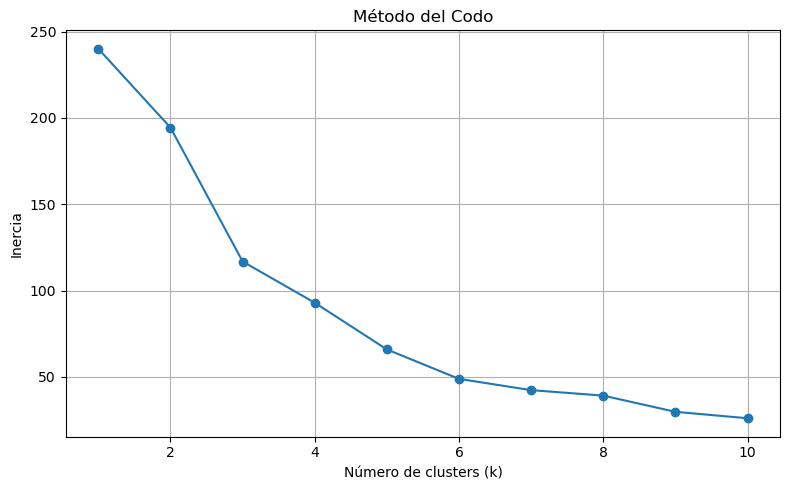

In [53]:
# Método del codo
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(variables_scaled_prop)
    inertia.append(kmeans.inertia_)

# Graficar la curva del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# Entrenar KMeans
kmeans_final_prop = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_final["cluster_propiedad"] = kmeans_final_prop.fit_predict(variables_scaled_prop)

# Ver el resultado
df_final[["barrio", "cluster_propiedad"] + list(variables_cluster_prop.columns)]


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,barrio,cluster_propiedad,precio_entire_home,precio_hotel_room,precio_private_room,precio_shared_room,total_delitos
0,AGRONOMIA,0,36758.0,0.0,15753.0,0.0,527
1,ALMAGRO,1,35350.0,0.0,19954.0,12603.0,6098
2,BALVANERA,1,33607.0,0.0,18904.0,45411.5,9996
3,BARRACAS,1,45684.5,0.0,18935.5,15753.0,5523
4,BELGRANO,1,42009.0,0.0,22895.0,10502.0,4989
5,BOCA,0,36758.0,0.0,21004.0,17219.5,2556
6,BOEDO,0,31086.0,0.0,16803.0,0.0,2052
7,CABALLITO,1,35633.5,0.0,21004.0,0.0,6559
8,CHACARITA,1,36758.0,0.0,19503.0,55514.0,2432
9,COGHLAN,0,32557.0,0.0,21004.0,0.0,547


In [55]:
df_final['cluster_propiedad'].value_counts().sort_index()

cluster_propiedad
0    31
1    15
2     2
Name: count, dtype: int64

In [56]:
#df_final[df_final["cluster_propiedad"] == 0]

Text(0.5, 1.0, 'Centroides por variable propiedad(estandarizados)')

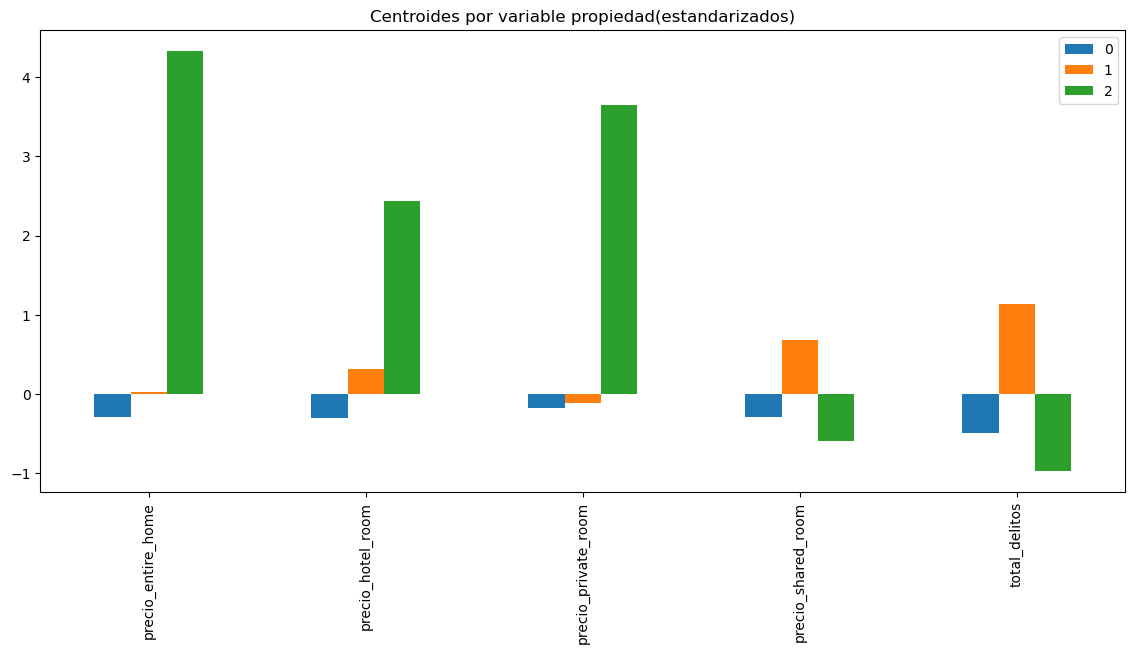

In [57]:
centroides = pd.DataFrame(kmeans_final_prop.cluster_centers_, columns=variables_cluster_prop.columns)
centroides.T.plot(kind='bar', figsize=(14, 6))
plt.title("Centroides por variable propiedad(estandarizados)")


C:\Users\maria\AppData\Local\Temp\ipykernel_18448\3643809749.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = mapa_clusters.geometry.centroid


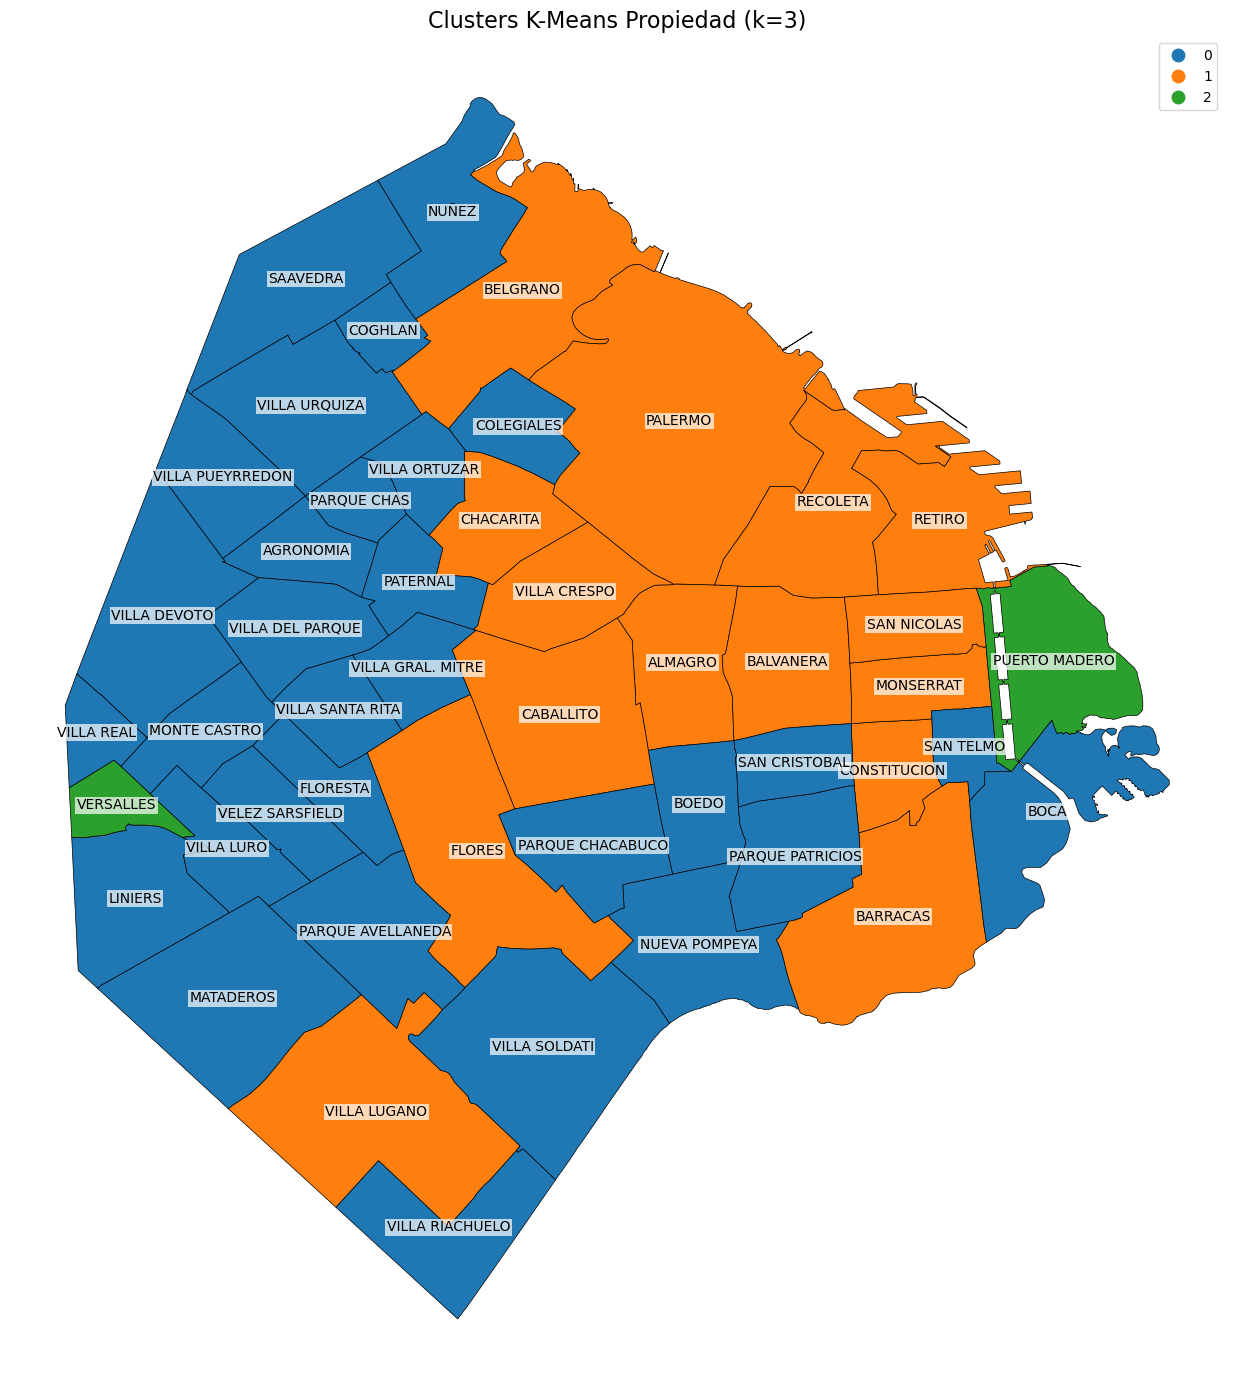

In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import ListedColormap

# 1. Merge de nuevo
mapa_clusters = barrios_gdf.merge(
    df_final[['barrio', 'cluster_propiedad']],
    on='barrio',
    how='left'
)

# 2. Definir colores personalizados para cada cluster
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # celeste, naranja, verde
cmap = ListedColormap(colors)

# 3. Gráfico con nombres
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
mapa_clusters.plot(
    column="cluster_propiedad",
    categorical=True,
    cmap=cmap,
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Dibujar nombres con fondo blanco
centroids = mapa_clusters.geometry.centroid
for idx, row in mapa_clusters.iterrows():
    x, y = centroids.loc[idx].x, centroids.loc[idx].y
    ax.text(
        x, y, row["barrio"],
        fontsize=10,  # Tamaño de fuente mayor
        ha="center", va="center",
        color="black",
        bbox=dict(
            facecolor="white", 
            edgecolor="none", 
            pad=1, 
            alpha=0.7
        )
    )

ax.set_title("Clusters K-Means Propiedad (k=3)", fontsize=16)
ax.axis("off")
plt.tight_layout()

# 4. Guardar la figura
fig.savefig("clusters_km_propiedad_barrio.png", dpi=300, bbox_inches="tight")

plt.show()



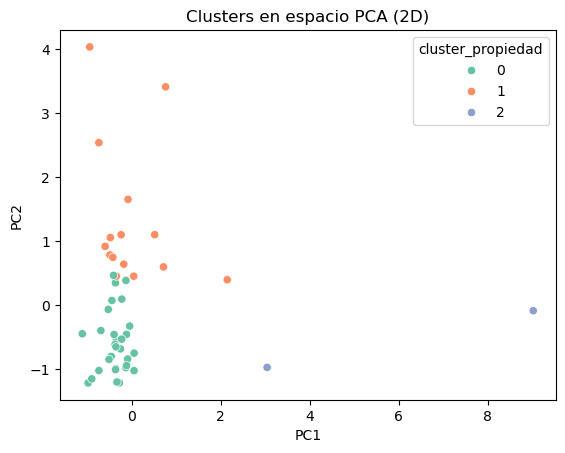

In [59]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
components = pca.fit_transform(variables_scaled_prop)

df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
df_pca['cluster_propiedad'] = df_final['cluster_propiedad']

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster_propiedad', palette='Set2')
plt.title("Clusters en espacio PCA (2D)")
plt.show()


In [60]:
# Calcula el Silhouette Score
sil_score_prop = silhouette_score(variables_scaled_prop, df_final["cluster_propiedad"])

print(f"Silhouette Score para KMeans (k=3): {sil_score_prop:.4f}")


Silhouette Score para KMeans (k=3): 0.3778


### ARI y Submuestreo para KM PROPIEDAD

In [62]:
# Matriz escalada para "propiedad"
X_prop = variables_scaled_prop  
# Etiquetas originales de K-Means sobre propiedad
labels_orig_prop = df_final["cluster_propiedad"].values  

# Parámetros de validación
B = 100  # Bootstrap
N = 50   # Submuestreo
n_sub = int(0.8 * len(X_prop))

# 1. Bootstrap
aris_boot_prop = []
for _ in range(B):
    idx = np.random.choice(len(X_prop), len(X_prop), replace=True)
    # Reentrenar KMeans con k igual al original (reemplaza k si es otro)
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=len(np.unique(labels_orig_prop)), random_state=42, n_init='auto')
    labels_boot = km.fit_predict(X_prop[idx])
    if len(np.unique(labels_boot)) > 1:
        aris_boot_prop.append(adjusted_rand_score(labels_orig_prop[idx], labels_boot))

# 2. Submuestreo (hold-out 80%)
aris_sub_prop = []
for _ in range(N):
    idx = np.random.choice(len(X_prop), n_sub, replace=False)
    km = KMeans(n_clusters=len(np.unique(labels_orig_prop)), random_state=42, n_init='auto')
    labels_sub = km.fit_predict(X_prop[idx])
    if len(np.unique(labels_sub)) > 1:
        aris_sub_prop.append(adjusted_rand_score(labels_orig_prop[idx], labels_sub))

# Compilar resultados
results_prop = pd.DataFrame({
    "Método": ["Bootstrap (B=100)", "Submuestreo 80% (N=50)"],
    "ARI Medio": [np.mean(aris_boot_prop), np.mean(aris_sub_prop)],
    "ARI STD":   [np.std(aris_boot_prop),  np.std(aris_sub_prop)]
})

results_prop


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

,Método,ARI Medio,ARI STD
0,Bootstrap (B=100),0.471538,0.270259
1,Submuestreo 80% (N=50),0.507950,0.281223


## KM con ocupación aprox

In [64]:
# Selecciono las variables
variables_cluster_oc = df_final[["precio_promedio_ponderado", "total_delitos","ocupacion_aproximada_mes"]].copy()

# Escalar las variables
scaler = StandardScaler()
variables_scaled_oc = scaler.fit_transform(variables_cluster_oc)

C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

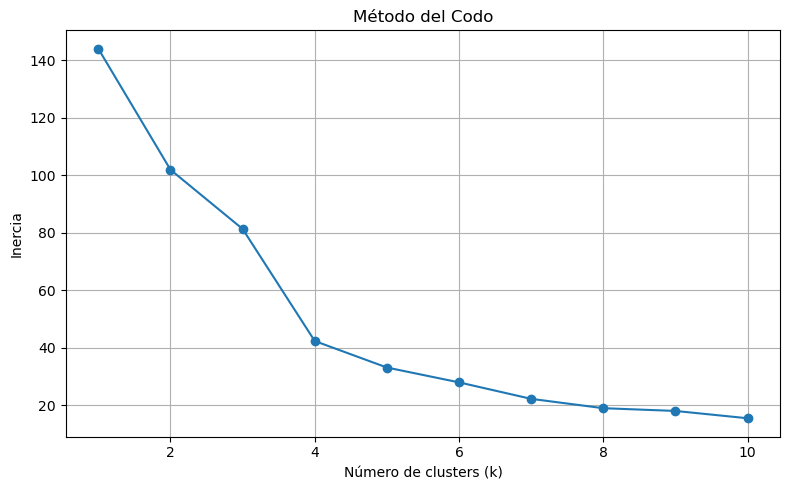

In [65]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Método del codo
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(variables_scaled_oc)
    inertia.append(kmeans.inertia_)

# Graficar la curva del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title("Método del Codo")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
# Entrenar KMeans
kmeans_final_oc = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_final["cluster_oc"] = kmeans_final_oc.fit_predict(variables_scaled_oc)

# Ver el resultado
df_final[["barrio", "cluster_oc"] + list(variables_cluster_oc.columns)]

C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,barrio,cluster_oc,precio_promedio_ponderado,total_delitos,ocupacion_aproximada_mes
0,AGRONOMIA,0,33257.166667,527,0.112359
1,ALMAGRO,2,33135.304878,6098,0.147964
2,BALVANERA,2,30184.960125,9996,0.152600
3,BARRACAS,2,40485.330798,5523,0.147074
4,BELGRANO,2,40809.730895,4989,0.173796
5,BOCA,0,33621.914062,2556,0.139246
6,BOEDO,0,28205.394958,2052,0.103430
7,CABALLITO,2,33772.350592,6559,0.150639
8,CHACARITA,0,34619.323383,2432,0.179863
9,COGHLAN,0,31894.122951,547,0.152767


In [67]:
# Contar cantidad de barrios por cluster
df_final['cluster_oc'].value_counts().sort_index()

cluster_oc
0    31
1     6
2     9
3     2
Name: count, dtype: int64

Text(0.5, 1.0, 'Centroides por variable ocupación(estandarizados)')

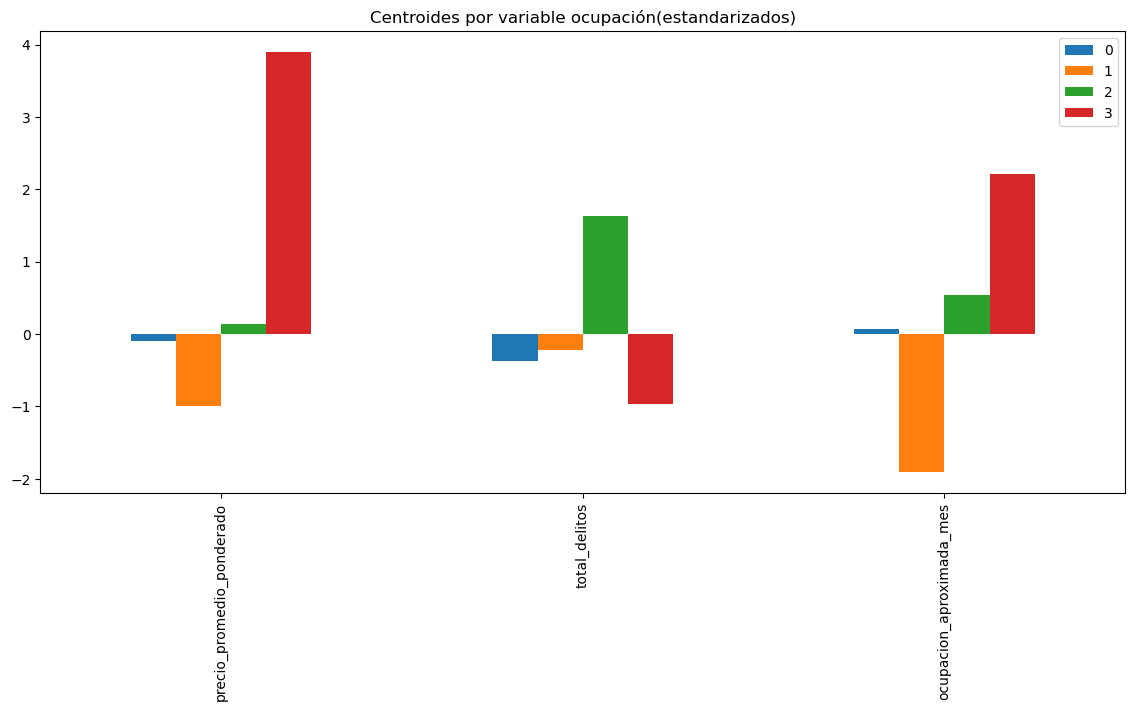

In [68]:
centroides = pd.DataFrame(kmeans_final_oc.cluster_centers_, columns=variables_cluster_oc.columns)
centroides.T.plot(kind='bar', figsize=(14, 6))
plt.title("Centroides por variable ocupación(estandarizados)")

C:\Users\maria\AppData\Local\Temp\ipykernel_18448\2282607285.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = mapa_clusters.geometry.centroid


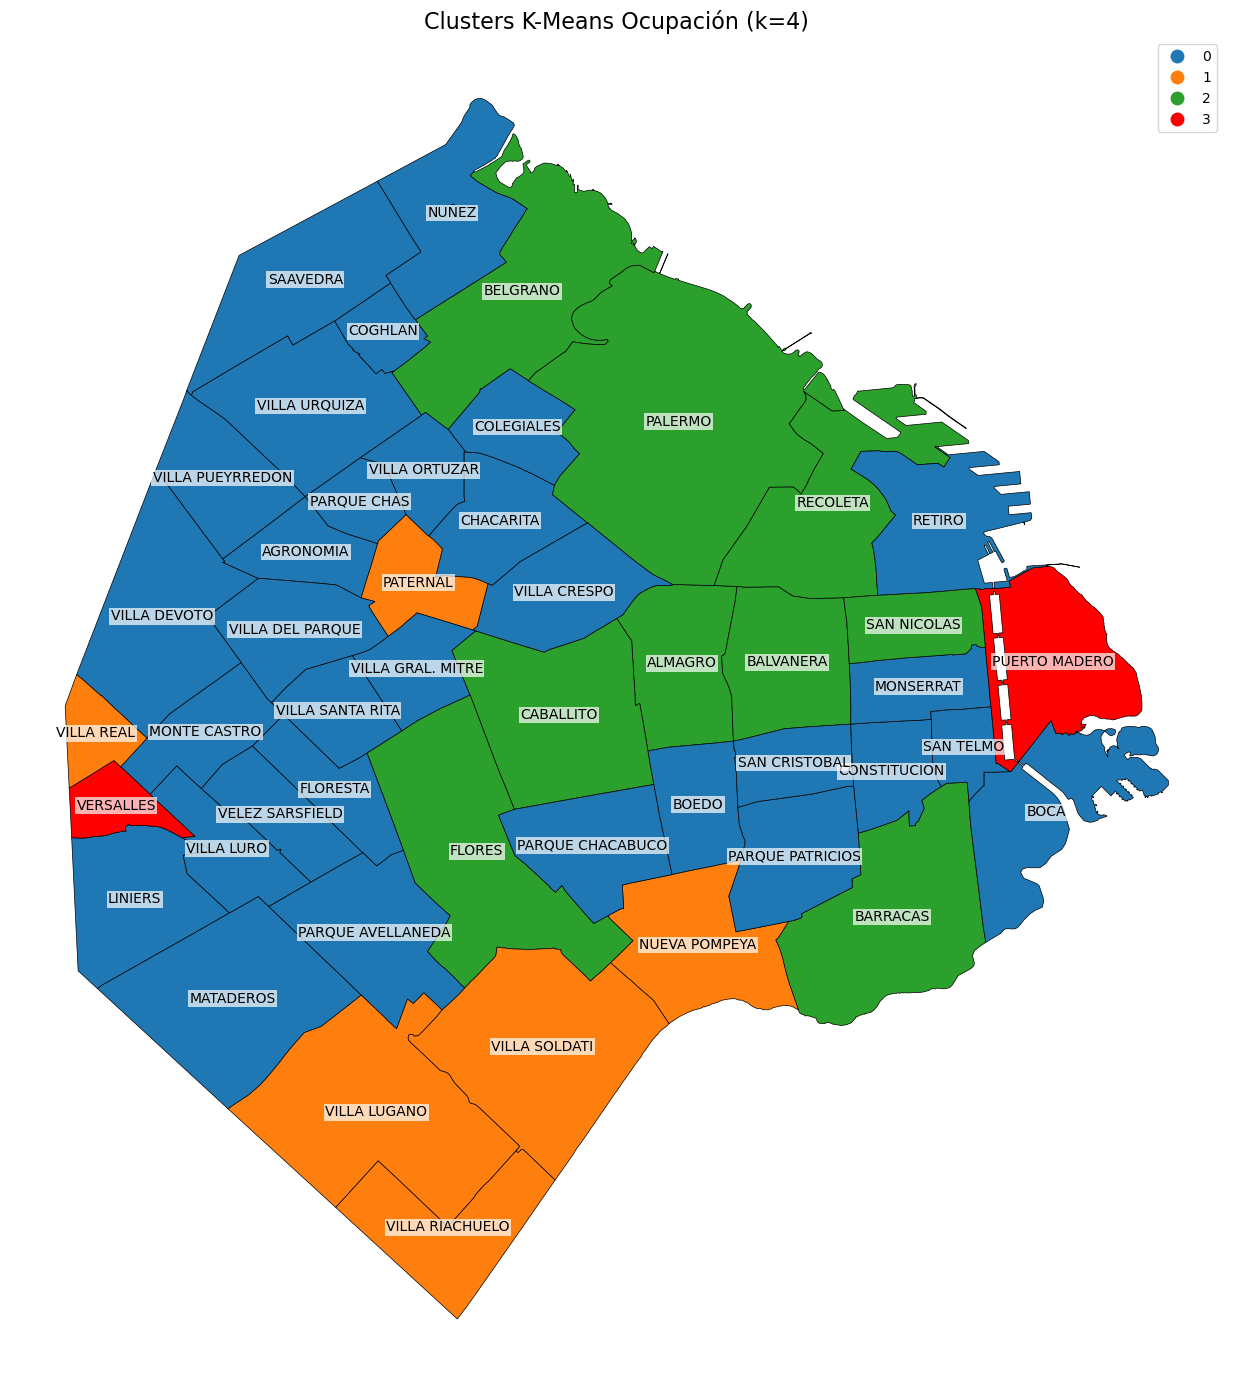

In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 1. Merge de nuevo
mapa_clusters = barrios_gdf.merge(
    df_final[['barrio', 'cluster_oc']],
    on='barrio',
    how='left'
)

# 2. Definir colores personalizados para cada cluster
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'red']  # celeste, naranja, verde, rojo
cmap = ListedColormap(colors)

# 3. Gráfico con nombres y fondo blanco para mejorar legibilidad
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
mapa_clusters.plot(
    column="cluster_oc",
    categorical=True,
    cmap=cmap,
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

# Dibujar nombres con fondo blanco
centroids = mapa_clusters.geometry.centroid
for idx, row in mapa_clusters.iterrows():
    x, y = centroids.loc[idx].x, centroids.loc[idx].y
    ax.text(
        x, y, row["barrio"],
        fontsize=10,  # Tamaño de fuente mayor
        ha="center", va="center",
        color="black",
        bbox=dict(
            facecolor="white", 
            edgecolor="none", 
            pad=1, 
            alpha=0.7
        )
    )

ax.set_title("Clusters K-Means Ocupación (k=4)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

# 4. Guardar la figura
fig.savefig("clusters_km_ocupacion_barrio.png", dpi=300, bbox_inches="tight")

plt.show()


In [70]:
# 1. Prepara tus datos
X_oc = variables_scaled_oc                              # matriz escalada para ocupación
labels_orig_oc = df_final["cluster_oc"].values          # etiquetas originales

# 2. Parámetros de validación
B = 100       # réplicas bootstrap
N = 50        # réplicas submuestreo
n_sub = int(0.8 * len(X_oc))

# 3. Bootstrap
aris_boot_oc = []
for _ in range(B):
    idx = np.random.choice(len(X_oc), len(X_oc), replace=True)
    km = KMeans(n_clusters=len(np.unique(labels_orig_oc)), random_state=42, n_init='auto')
    labels_boot = km.fit_predict(X_oc[idx])
    if len(np.unique(labels_boot)) > 1:
        aris_boot_oc.append(adjusted_rand_score(labels_orig_oc[idx], labels_boot))

# 4. Submuestreo 80%
aris_sub_oc = []
for _ in range(N):
    idx = np.random.choice(len(X_oc), n_sub, replace=False)
    km = KMeans(n_clusters=len(np.unique(labels_orig_oc)), random_state=42, n_init='auto')
    labels_sub = km.fit_predict(X_oc[idx])
    if len(np.unique(labels_sub)) > 1:
        aris_sub_oc.append(adjusted_rand_score(labels_orig_oc[idx], labels_sub))

# 5. Muestra los resultados
df_stab_oc = pd.DataFrame({
    "Método": ["Bootstrap (B=100)", "Submuestreo 80% (N=50)"],
    "ARI Medio": [np.mean(aris_boot_oc), np.mean(aris_sub_oc)],
    "ARI STD":   [np.std(aris_boot_oc),  np.std(aris_sub_oc)]
})
print(df_stab_oc)


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

                   Método  ARI Medio   ARI STD
0       Bootstrap (B=100)   0.535694  0.231159
1  Submuestreo 80% (N=50)   0.660916  0.243361


C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maria\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Cuadro comparativo

In [72]:
# Calcula el Silhouette Score
sil_score = silhouette_score(variables_scaled_ponderado, df_final["cluster_ponderado"])

print(f"Silhouette Score para KMeans (k=3): {sil_score:.4f}")

sil_score_dbscan = silhouette_score(X_scaled_dbscan, df_final["cluster_dbscan"])
sil_score_dbscan


Silhouette Score para KMeans (k=3): 0.5129


0.7429587841004786

In [73]:
sil_score_propiedad = silhouette_score(variables_scaled_prop, df_final["cluster_propiedad"])
sil_score_propiedad

0.3778002990428206

In [74]:
sil_score_oc=silhouette_score(variables_scaled_oc, df_final["cluster_oc"])
sil_score_oc

0.4218737888228022

In [75]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

experimentos = [
    ("KM  ponderado",   variables_scaled_ponderado, "cluster_ponderado"),
    ("KM  propiedad",   variables_scaled_prop,      "cluster_propiedad"),
    ("KM  ocupacion",   variables_scaled_oc,        "cluster_oc"),
    ("DBSCAN",          X_scaled_dbscan,            "cluster_dbscan"),
]

for nombre, X_scaled, col in experimentos:
    labels = df_final[col]

    # Para DBSCAN, opcionalmente filtramos el ruido
    if nombre == "DBSCAN":
        mask = labels != -1
        X_eval, lbls = X_scaled[mask], labels[mask]
    else:
        X_eval, lbls = X_scaled, labels

    # Comprobar cuántos clusters reales hay
    unique_labels = np.unique(lbls)
    if unique_labels.size > 1:
        sil = silhouette_score(X_eval, lbls)
        db  = davies_bouldin_score(X_eval, lbls)
    else:
        sil = np.nan
        db  = np.nan

    print(f"{nombre:15s} → Clusters={unique_labels.size:2d}  "
          f"Silhouette={sil:6.4f}  DB={db:6.4f}")


KM  ponderado   → Clusters= 3  Silhouette=0.5129  DB=0.5220
KM  propiedad   → Clusters= 3  Silhouette=0.3778  DB=1.1078
KM  ocupacion   → Clusters= 4  Silhouette=0.4219  DB=0.7550
DBSCAN          → Clusters= 1  Silhouette=   nan  DB=   nan


In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Define los experimentos a evaluar
experimentos = [
    ("KMeans ponderado", variables_scaled_ponderado, "cluster_ponderado"),
    ("KMeans propiedad", variables_scaled_prop,      "cluster_propiedad"),
    ("KMeans ocupación", variables_scaled_oc,        "cluster_oc"),
    ("DBSCAN",            X_scaled_dbscan,            "cluster_dbscan"),
]

# Acumulamos resultados en una lista de diccionarios
rows = []
for nombre, X_scaled, col in experimentos:
    labels = df_final[col].values
    if nombre == "DBSCAN":
        mask = labels != -1
        X_eval, lbls = X_scaled[mask], labels[mask]
    else:
        X_eval, lbls = X_scaled, labels

    unique_labels = np.unique(lbls)
    if unique_labels.size > 1:
        sil = silhouette_score(X_eval, lbls)
        db  = davies_bouldin_score(X_eval, lbls)
    else:
        sil = np.nan
        db  = np.nan

    rows.append({
        "Método":         nombre,
        "Clusters":       unique_labels.size,
        "Silhouette":     sil,
        "Davies–Bouldin": db
    })

# Convertimos a DataFrame y mostramos
df_metrics = pd.DataFrame(rows)
df_metrics



,Método,Clusters,Silhouette,Davies–Bouldin
0,KMeans ponderado,3,0.512937,0.522000
1,KMeans propiedad,3,0.377800,1.107793
2,KMeans ocupación,4,0.421874,0.755028
3,DBSCAN,1,NaN,NaN


In [77]:
import pandas as pd

# Supón que ya tienes estos DataFrames en tu notebook:
# results_ponderado, results_prop, df_stab_oc, df_stab_db

# Añadimos la columna 'Experimento' a cada DataFrame
results_ponderado = results_ponderado.copy()
results_ponderado['Experimento'] = 'KM ponderado'

results_prop = results_prop.copy()
results_prop['Experimento'] = 'KM propiedad'

df_stab_oc = df_stab_oc.copy()
df_stab_oc['Experimento'] = 'KM ocupación'

df_stab_db = df_stab_db.copy()
df_stab_db['Experimento'] = 'DBSCAN'

# Concatenamos todos
df_aris = pd.concat([
    results_ponderado,
    results_prop,
    df_stab_oc,
    df_stab_db
], ignore_index=True)

# Reordenamos columnas
df_aris = df_aris[['Experimento', 'Método', 'ARI Medio', 'ARI STD']]
df_aris
# Mostramos al usuario
#import ace_tools as tools; tools.display_dataframe_to_user(name="Resumen ARI de Experimentos", dataframe=df_aris)


,Experimento,Método,ARI Medio,ARI STD
0,KM ponderado,Bootstrap (B=100),0.651228,0.251331
1,KM ponderado,Submuestreo 80% (N=50),0.753354,0.235757
2,KM propiedad,Bootstrap (B=100),0.471538,0.270259
3,KM propiedad,Submuestreo 80% (N=50),0.507950,0.281223
4,KM ocupación,Bootstrap (B=100),0.535694,0.231159
5,KM ocupación,Submuestreo 80% (N=50),0.660916,0.243361
6,DBSCAN,Bootstrap (B=100),0.678092,0.389720
7,DBSCAN,Submuestreo 80% (N=50),0.773216,0.279257


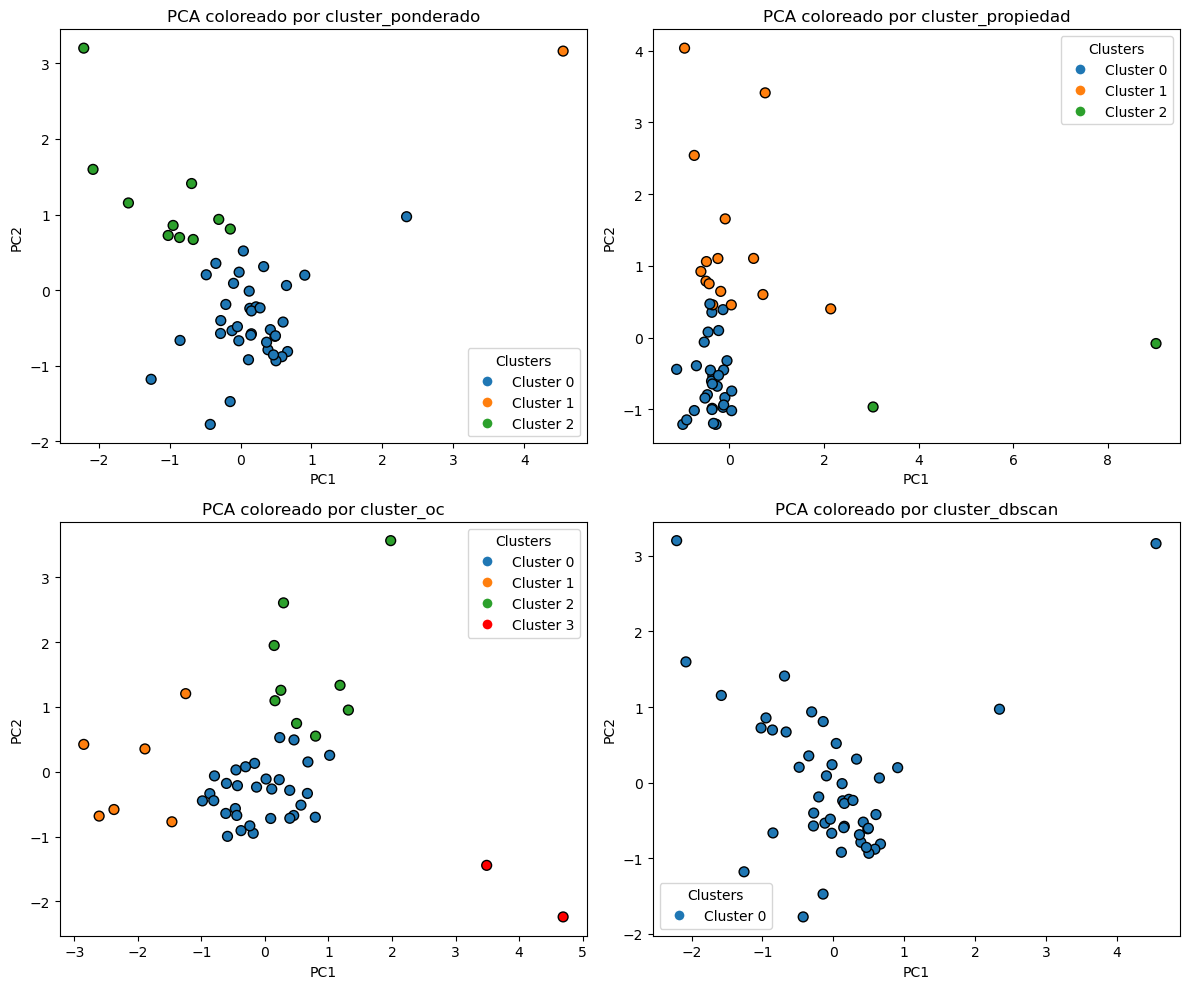

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, BoundaryNorm

# Definición del mapeo de clusters a matrices escaladas
mapping = {
    'cluster_ponderado': variables_scaled_ponderado,
    'cluster_propiedad': variables_scaled_prop,
    'cluster_oc':        variables_scaled_oc,
    'cluster_dbscan':    X_scaled_dbscan
}

# Colores fijos para cada etiqueta de cluster
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 'red']
# Norm para asignar valores enteros de cluster a colores
norm = BoundaryNorm(boundaries=np.arange(-0.5, 4.5, 1), ncolors=len(cluster_colors))

# Configurar figura con 2 gráficos por fila
n = len(mapping)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))
axes = axes.flatten()

for ax, (col, X_scaled) in zip(axes, mapping.items()):
    # Proyección PCA
    X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
    labels = df_final[col].values

    # Dibujar scatter con colormap fijo
    scatter = ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels,
        cmap=ListedColormap(cluster_colors),
        norm=norm,
        s=50,
        edgecolor='k'
    )
    ax.set_title(f"PCA coloreado por {col}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    # Leyenda manual para los clusters
    handles = []
    for i, color in enumerate(cluster_colors):
        # Solo incluir los clusters presentes en esta partición
        if i in np.unique(labels):
            handles.append(plt.Line2D([], [], marker='o', color='w',
                                      markerfacecolor=color, markersize=8,
                                      label=f'Cluster {i}'))
    ax.legend(handles=handles, title="Clusters", loc='best')

# Eliminar ejes sobrantes
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
# Guardar la figura
fig.savefig("pca_clusters_custom_colors.png", dpi=300, bbox_inches="tight")
plt.show()


In [79]:
comparison = df_final[['barrio',
                       'cluster_ponderado',
                       'cluster_propiedad',
                       'cluster_oc',
                       'cluster_dbscan']].sort_values('barrio').reset_index(drop=True)

from IPython.display import display
display(comparison)

,barrio,cluster_ponderado,cluster_propiedad,cluster_oc,cluster_dbscan
0,AGRONOMIA,0,0,0,0
1,ALMAGRO,2,1,2,0
2,BALVANERA,2,1,2,0
3,BARRACAS,2,1,2,0
4,BELGRANO,2,1,2,0
5,BOCA,0,0,0,0
6,BOEDO,0,0,0,0
7,CABALLITO,2,1,2,0
8,CHACARITA,0,1,0,0
9,COGHLAN,0,0,0,0


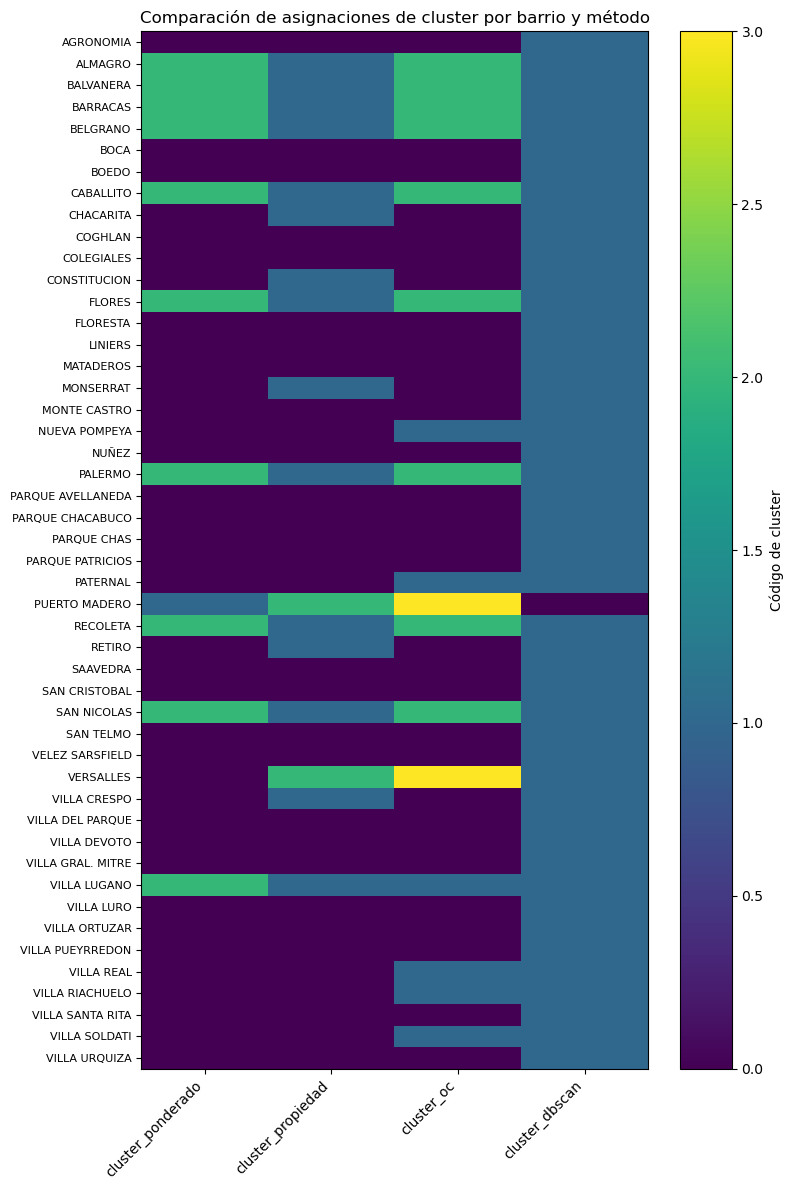

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepara la tabla comparativa
comp = df_final[['barrio',
                 'cluster_ponderado',
                 'cluster_propiedad',
                 'cluster_oc',
                 'cluster_dbscan']].copy()

# Índice por barrio, ordenados alfabéticamente
comp = comp.set_index('barrio').sort_index()

# 2. Codifica etiquetas a enteros
comp_codes = comp.apply(lambda col: col.astype('category').cat.codes)

# 3. Dibuja el heatmap con matplotlib
fig, ax = plt.subplots(figsize=(8, 12))
im = ax.imshow(comp_codes.values, aspect='auto')

# Etiquetas de ejes
ax.set_xticks(np.arange(comp_codes.shape[1]))
ax.set_xticklabels(comp_codes.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(comp_codes.shape[0]))
ax.set_yticklabels(comp_codes.index, fontsize=8)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Código de cluster')

# Título y ajuste
plt.title('Comparación de asignaciones de cluster por barrio y método')
plt.tight_layout()
plt.show()
fig.savefig("Comparación de asignaciones de cluster por barrio y método.png", dpi=300, bbox_inches="tight")
plt.show()

In [81]:
# Filtrar barrios con cluster idéntico en los tres KMeans
mask = (
    (df_final['cluster_ponderado'] == df_final['cluster_propiedad']) &
    (df_final['cluster_ponderado'] == df_final['cluster_oc'])
)
stable_barrios = df_final[mask]

# Cálculo de cifras
total = len(df_final)
n_estables = len(stable_barrios)
pct_estables = n_estables / total * 100

print(f"Total de barrios: {total}")
print(f"Barrios estables (mismo cluster en los 3 KMeans): {n_estables}")
print(f"Porcentaje de barrios estables: {pct_estables:.1f}%")

# Opcional: listar sus nombres
print("\nBarrios estables:")
print(stable_barrios['barrio'].tolist())


Total de barrios: 48
Barrios estables (mismo cluster en los 3 KMeans): 26
Porcentaje de barrios estables: 54.2%

Barrios estables:
['AGRONOMIA', 'BOCA', 'BOEDO', 'COGHLAN', 'COLEGIALES', 'FLORESTA', 'LINIERS', 'MATADEROS', 'MONTE CASTRO', 'NUÑEZ', 'PARQUE AVELLANEDA', 'PARQUE CHACABUCO', 'PARQUE CHAS', 'PARQUE PATRICIOS', 'SAAVEDRA', 'SAN CRISTOBAL', 'SAN TELMO', 'VELEZ SARSFIELD', 'VILLA DEL PARQUE', 'VILLA DEVOTO', 'VILLA GRAL. MITRE', 'VILLA LURO', 'VILLA ORTUZAR', 'VILLA PUEYRREDON', 'VILLA SANTA RITA', 'VILLA URQUIZA']


In [82]:
# 1. Calcular la ocupación promedio por cluster
ocup_por_cluster = (
    df_final
    .groupby("cluster_ponderado")["ocupacion_aproximada_mes"]
    .mean()
    .reset_index(name="ocupacion_promedio_mes")
)

print(ocup_por_cluster)

   cluster_ponderado  ocupacion_promedio_mes
0                  0                0.135018
1                  1                0.235819
2                  2                0.160454
